# Single Subject MRI and fMRI Preprocessing Using Nilearn

#### Author: Ogulcan ULU


## Magnetic Resonance Imaging (MRI)

Magnetic Resonance Imaging (MRI) is a non-invasive imaging technique that uses strong magnetic fields and radio frequency pulses and paramagnetic properties of the atoms and molecules in tissues in order to generate detailed images of those tissues. By detecting differences in tissue properties for instance water content and fat distribution it provides high resolution anatomical structural images. It is widely used practice in medical diagnostic, neuroscience and research.

### Key Feautres of MRI:

- **High anatomical resolution**: Captures detailed brain structures.
- **Non-invasive and safe**: Uses no ionizing radiation.
- **Different imaging contrasts**: Uses different relaxation times of the tissues to generate T1-weighted, T2-weighted, and proton density weightened.

## Functional Magnetic Resonance Imaging (fMRI)

fMRI extends traditional MRI imaging by measuring brain activity based on changes in blood flow by measuring **Blood Oxygen Level Dependent (BOLD)** signal, which reflects variations in oxygenated and deoxygenated blood in active brain regions. However, it is cruicial to keep in mind that what we are measuring here ***IS NOT BRAIN ACTIVITY ITSELF*** rather what we are measuring is blood flow to regions and we assume that increased blood consumption on those sites are related with oxygen and nutrition demand therefore activation. fMRI is commonly used technique especially in cognitive neuroscience studies in order to infer neural substrates of certain cognitive tasks.

### Key Features of fMRI:
- **Measures brain activity indirectly** via blood flow changes.
- **BOLD contrast**: Increased neural activity leads to increased oxygenated blood supply.
- **Time-sensitive but lower spatial resolution than anatomical MRI**.
- **Used in cognitive and clinical research**: Studying mental processes.


**Dataset used in this project:**

Yana Panikratova and Alexander Tomyshev and Ekaterina Pechenkova and Roza Vlasova (2021). fMRI: resting state and arithmetic task. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds002422.v1.0.2


---

### Analysing MRI / fMRI Data

The most common format of neuroimaging data is NIfTI (.nii or .nii.gz).

#### Required Libraries:

In [ ]:
!pip install nilearn nibabel numpy pandas matplotlib seaborn scipy SimpleITK

In [14]:
#Defining a function to load neuroimaging data.

import nibabel as nib

def load_mri_images(file_path):
    img=nib.load(file_path)
    return img

In [15]:
image_mri=load_mri_images('/Users/ogulcanulu/Desktop/CONN_Demo/sub-01/anat/sub-01 anat sub-01_T1w.nii')

In [16]:
print(f"Image shape: {image_mri.shape}")
print("\n")
print(f"Data type: {image_mri.get_data_dtype()}")
print("\n")
print(f"Affine matrix:\n{image_mri.affine}")

Image shape: (256, 256, 176)


Data type: float32


Affine matrix:
[[ 2.48316526e-02 -8.50379467e-03  9.99638736e-01 -9.12353592e+01]
 [-9.73526239e-01 -7.30670691e-02  2.47059464e-02  1.29153763e+02]
 [-7.28305578e-02  9.73788083e-01  1.05832219e-02 -1.53458725e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


---
We have succesfully uploaded our anatomical MRI data and retrieved its properties.

**Shape of the Image (256, 256, 176):** This means that MRI scan consists of 176 different slices each with resolution of 256 x 256 matrix. Each value in this matrix representing a voxel.

**Data Type: float32:** Means that voxel intensities are stored as 32-bit floating point numbers. This is also important because floating numbers can reflect tissue contrast, and these values can be used for segmentation or intensity-based processing.

**Affine Matrix:** This is a 4x4 transformation matrix that maps voxel coordinates to real-world coordinates in milimeters. The first three rows define the x, y and z orientations adn the last column represents the translation.

Affine matrices are crucial in neuroimaging preprocessing, as they account for head movement, scanner alignment, and spatial normalization. Understanding the affine matrix helps correct for misalignments, tilts, and distortions due to head motion during MRI acquisition.

#### Our affine matrix tells us

- **Row 1 ([0.0248, -0.0085, 0.9996, -91.24])**

This controls the X-axis (left-right).
Since 0.9996 is in the Z column, this means that the X-axis is slightly tilted along Z.

- **Row 2 ([-0.9735, -0.0731, 0.0247, 129.15])**

This controls the Y-axis (front-back).
The negative number (-0.9735) means the Y-axis is flipped slightly.

- **Row 3 ([-0.0728, 0.9738, 0.0106, -153.46])**

This controls the Z-axis (top-bottom).
Since the largest number is in the Y position (0.9738), it means Z is mostly aligned with Y.

- **Last Column ([-91.24, 129.15, -153.46])**

This means our brain scan is not at (0,0,0), but shifted in scanner space. In our case it is shifted to left on x axis (-91.24), forward in y axis (129.15), and downwards in the scanner on z axis (-153.46)

---

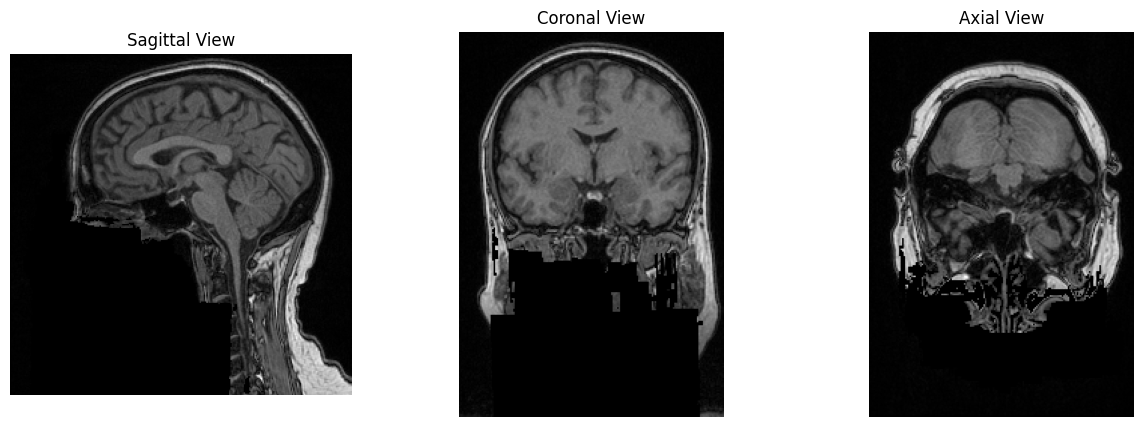

In [18]:
#Visualizing Raw MRI Image

import matplotlib.pyplot as plt

mri_data=image_mri.get_fdata() #converting MRI data to NumPy array

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sagittal View
axes[0].imshow(mri_data[:, :, mri_data.shape[2] // 2].T, cmap="gray", origin="lower")
axes[0].set_title("Sagittal View")

# Coronal View
axes[1].imshow(mri_data[mri_data.shape[0] // 2, :, :], cmap="gray", origin="lower")
axes[1].set_title("Coronal View")

# Axial View
axes[2].imshow(mri_data[:, mri_data.shape[1] // 2 , :], cmap="gray", origin="lower")
axes[2].set_title("Axial View")

for ax in axes:
    ax.axis("off")

plt.show()



## Preprocessing

Preprocessing is a crucial step in MRI and fMRI analysis to improve the quality and reliability of data before statistical and machine learning-based analyses.

Key Preprocessing Steps Are:

- Motion Correction
- Slice Timing Correction (for fMRI)
- Spatial Normalization
- Bias Field Correction
- Noise Reduction
- Skull Stripping
- Smoothing
- Temporal Filtering (for fMRI)

---

- #### Motion correction

Ideally what we would expect from subjects to stay in complete steadiness during MRI image acqusition however, such expectation is not realistic. During acquisiton, subjects move slightly during scan, brain changes position between slices this causes misalignment between acquired slices. In order to correct this misalignment we need a reference point to compare and manipulate our data.

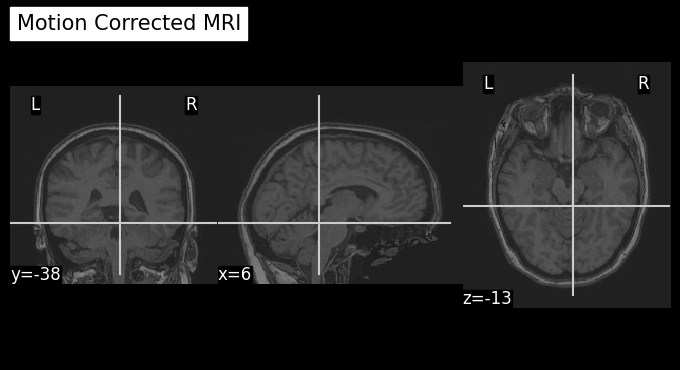

In [21]:
#Starting with Motion Correction
from nilearn.image import resample_to_img
from nilearn import datasets, plotting

#For structural image I will use MNI152 as template to correct motion.

template = datasets.load_mni152_template ()

corrected_image=resample_to_img(image_mri,template, force_resample=True, copy_header=True)

#Plotting Corrected Image

plotting.plot_anat(corrected_image, title="Motion Corrected MRI")
plotting.show()

#### What Happened Here?

- This reference point is the template we are using to standardize our MRI image regarding to the template. In this script MNI152 is the template.
- We have resampled our image to reposition to match MNI152 template with the code ```resample_to_img(image_mri,template)``` . In this code ```image_mri``` is the variable that contains our NIfTI formatted MRI image and ```template``` is the MNI152 template we have imported.

- #### Bias Field Correction

Since there are inhomogenities in the magnetic field that is generated along with the Z axis of the MRI scanner this results in inhomogenities along with the magnetic field. Some parts of the brain appear brighter than they should or some parts appear darker even though they have the same tissue type. Bias Field Correction corrects our image to have consistent intensitiy values in the same type of tissues across the image and make it easier to algorithms to detect different brain regions easier.

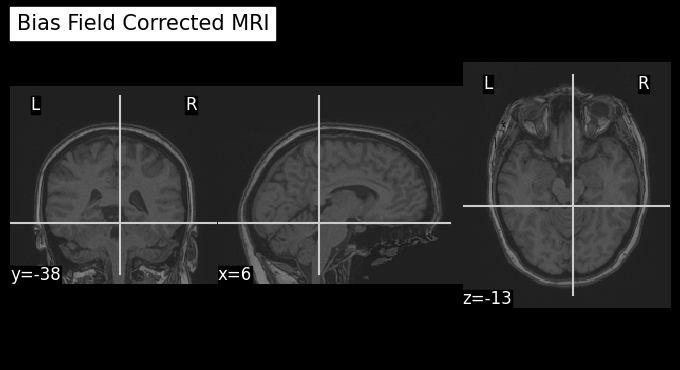

In [24]:
#Moving on with the Bias Field Correction
import SimpleITK as sitk

bias_1=sitk.GetImageFromArray(corrected_image.get_fdata())
bias_filter=sitk.N4BiasFieldCorrectionImageFilter()
bias_2=bias_filter.Execute(bias_1)
bias_field_corrected_image=nib.Nifti1Image(sitk.GetArrayFromImage(bias_2), affine=corrected_image.affine)

#Plotting
plotting.plot_anat(bias_field_corrected_image, title="Bias Field Corrected MRI")
plotting.show()

#### What Happened Here?

- First we have extracted voxel data from our previously motion corrected image -Remember that it was in NIfTI format- with the code ```bias_1=sitk.GetImageFromArray(corrected_image.get_fdata())``` this step prepares our image to processed with the N4ITK algorithm.
  
- Second we have created a correction filter and store it in a variable in order to apply it later with the code ```bias_filter=sitk.N4BiasFieldCorrectionImageFilter()```
  
- In the third step we have applied the stored correction filter on the image we have processed in the first step. ```bias_2=bias_filter.Execute(bias_1)```

- This filter application generates a new image the bias field correction applied however this generated image again needs to be reconverted to NIfTI. ```bias_field_corrected_image=nib.Nifti1Image(sitk.GetArrayFromImage(bias_2), affine=corrected_image.affine)``` this code extracts voxel data from the bias field filter applied image and wraps it in a NIfTI format. ```affine=corrected_image.affine()``` ensures that it stays in correct coordinate space with the corrected image.


- #### Skull Stripping
  Now we have corrected motion and bias field inhomogeneities, we also need to remove non-brain tissues from MRI scan (for some medical imaging scalp and skull could be necessary to keep in order to detect anomalies in those tissues however, when it comes to analyze just brain in neuroscientific research those voxels correesponding to skull and scalp tissue might interfere our data. Therefore leaving cranial tissues rather than surrounding tissues might be helpful in neuroscience research if our interest is just to analyze brain.

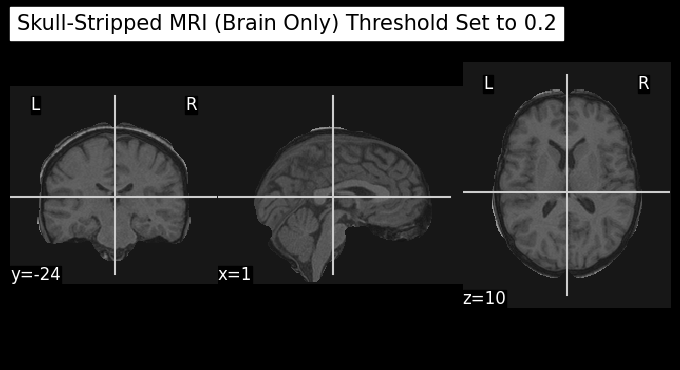

In [27]:
#Extracting Brain
from nilearn.masking import compute_brain_mask, apply_mask, unmask

brain_mask=compute_brain_mask(bias_field_corrected_image, threshold=0.2) #Pay attention that variable here is
#the last checkpoint. It is the image both motion correction and bias field correction applied.

extracted_brain_data=apply_mask(bias_field_corrected_image, brain_mask)

extracted_brain_img=unmask(extracted_brain_data, brain_mask)

plotting.plot_anat(extracted_brain_img, title="Skull-Stripped MRI (Brain Only) Threshold Set to 0.2")
plotting.show()

**In the following image we can see stripped image when threshold set to 0.4 We can appreciate that there are so many missing voxels at different levels.**

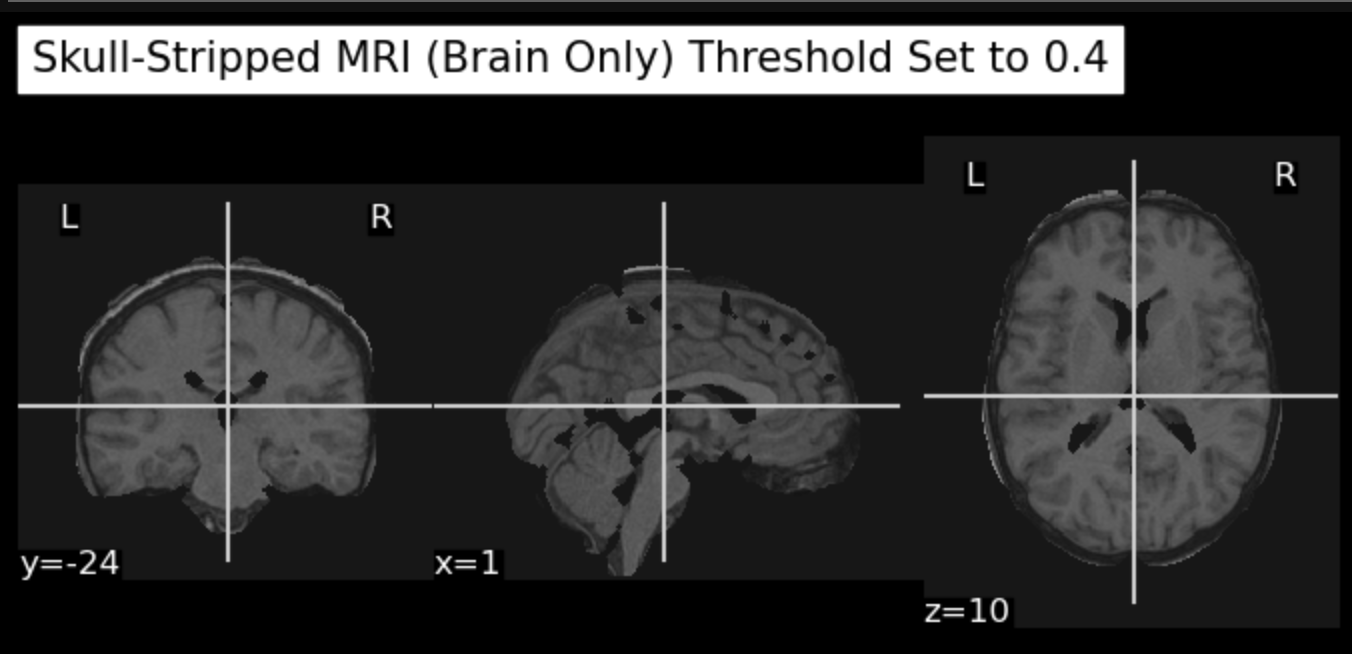

**In the following image we can see stripped image when threshold set to 0.3! We can appreciate that there are lack of voxels at the level of optic radiation bilaterally**

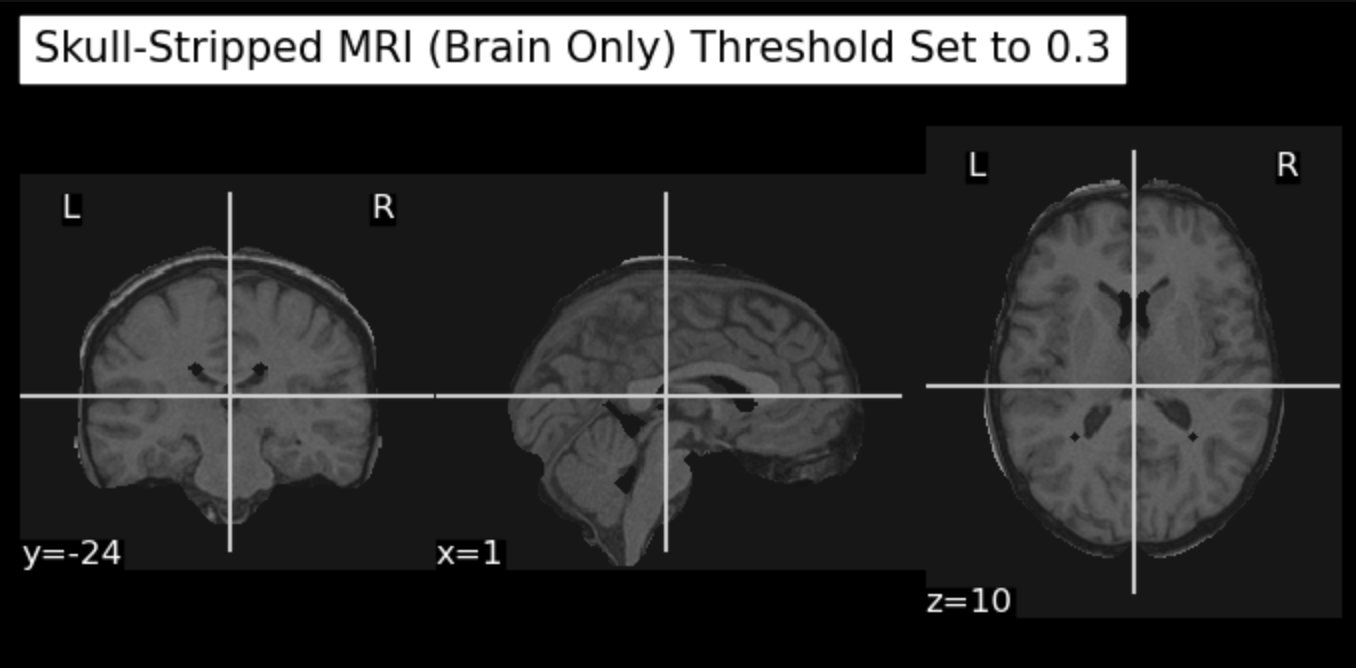

**Therefore threshold parameter set to 0.2 in order to prevent data loss while extracting brain from the skull**


#### What Happened Here?

- With the code ```brain_mask = compute_brain_mask(bias_field_corrected_image, threshold=0.2)``` First we have generated a mask that identifies which regions of the previous image contain brain tissue and we have set threshold to 0.2 because of the reason explained previously. Be aware that lower values keep more brain tissue while higher values remove more non-brain tissue but risk losing the interested brain tissue.

- Second we have applied this mask to our corrected data with the code ```extracted_brain_data = apply_mask(bias_field_corrected_image, brain_mask)```

- Third we restore the masked brain data back into 3D image because appying mask flattens data to 1D array. Unmasking ensures spatial dimension remain correct ```extracted_brain_img = unmask(extracted_brain_data, brain_mask)```

#### Since analysing group level or two subject analysis is out of scope of this notebook no further normalization is needed. What we will do is analyse individual brain and segmentation.

---

### Tissue Segmentation

Now we have preprocessed MRI data, we can proceed with segmenting into different tissue types based on their intensity. 

In anatomical MRI three main tissue type we can segment into are:

- Gray Matter
- White Matter
- Cerebrospinal Fluid

There are different approaches tissue segmentation, we will use here the atlas-based method which use pre-defined anatomial templates. Other approaches are data-driven such as Gaussian Mixture Model or clustering techniques.

[get_dataset_dir] Dataset found in /Users/ogulcanulu/nilearn_data/icbm152_2009


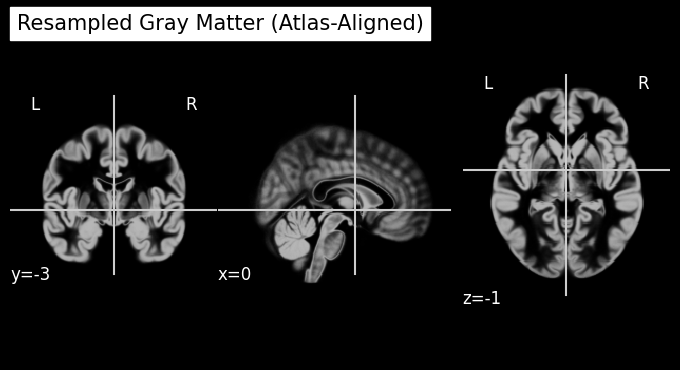

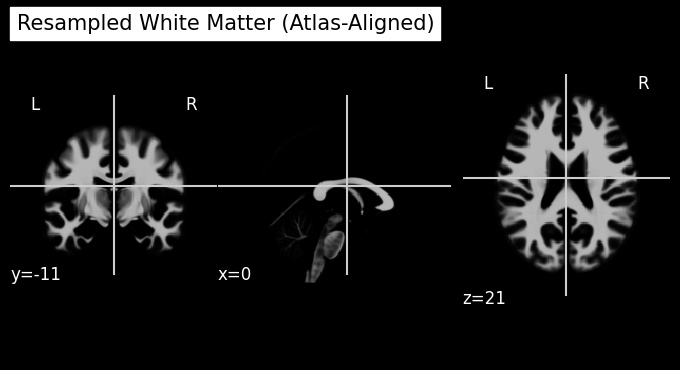

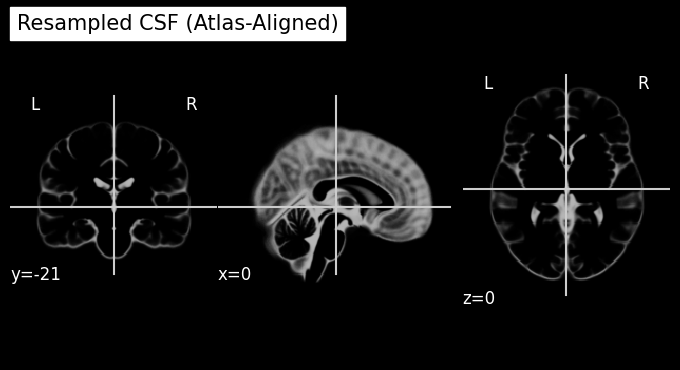

In [31]:
from nilearn import datasets, image, plotting

# Load MNI152
tissue_maps = datasets.fetch_icbm152_2009()

gm_atlas = image.load_img(tissue_maps.gm)
wm_atlas = image.load_img(tissue_maps.wm)
csf_atlas = image.load_img(tissue_maps.csf)

# Resample to match subject MRI
gm_resampled = image.resample_to_img(gm_atlas, extracted_brain_img, interpolation='continuous', force_resample=True, copy_header=True)
wm_resampled = image.resample_to_img(wm_atlas, extracted_brain_img, interpolation='continuous', force_resample=True, copy_header=True)
csf_resampled = image.resample_to_img(csf_atlas, extracted_brain_img, interpolation='continuous', force_resample=True, copy_header=True)

# Visualize resampled priors
plotting.plot_anat(gm_resampled, title="Resampled Gray Matter (Atlas-Aligned)")
plotting.plot_anat(wm_resampled, title="Resampled White Matter (Atlas-Aligned)")
plotting.plot_anat(csf_resampled, title="Resampled CSF (Atlas-Aligned)")
plotting.show()


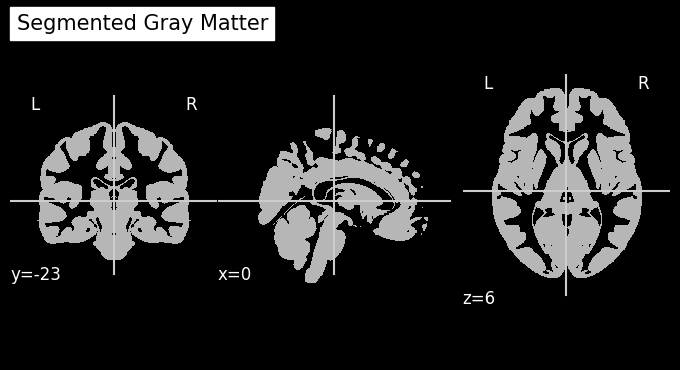

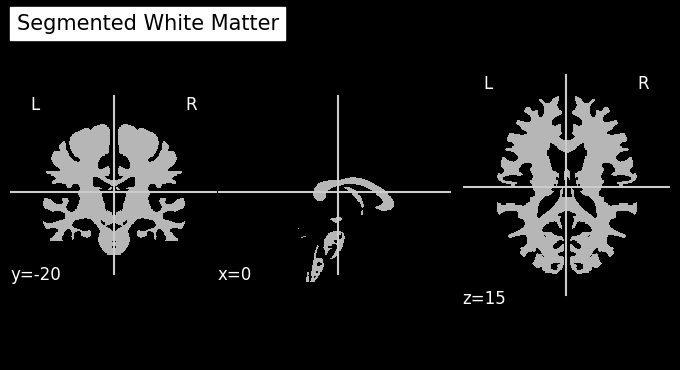

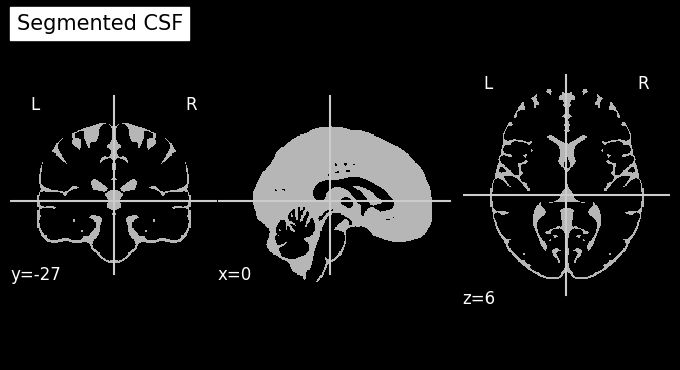

In [32]:
import numpy as np
from nilearn.image import new_img_like

# Convert to numpy arrays
gm_data = gm_resampled.get_fdata()
wm_data = wm_resampled.get_fdata()
csf_data = csf_resampled.get_fdata()

gm_mask = gm_data > 0.3
wm_mask = wm_data > 0.3
csf_mask = csf_data > 0.2

# Convert back to NIfTI images
gm_segmented = new_img_like(extracted_brain_img, gm_mask.astype(np.int32))
wm_segmented = new_img_like(extracted_brain_img, wm_mask.astype(np.int32))
csf_segmented = new_img_like(extracted_brain_img, csf_mask.astype(np.int32))

plotting.plot_anat(gm_segmented, title="Segmented Gray Matter")
plotting.plot_anat(wm_segmented, title="Segmented White Matter")
plotting.plot_anat(csf_segmented, title="Segmented CSF")
plotting.show()


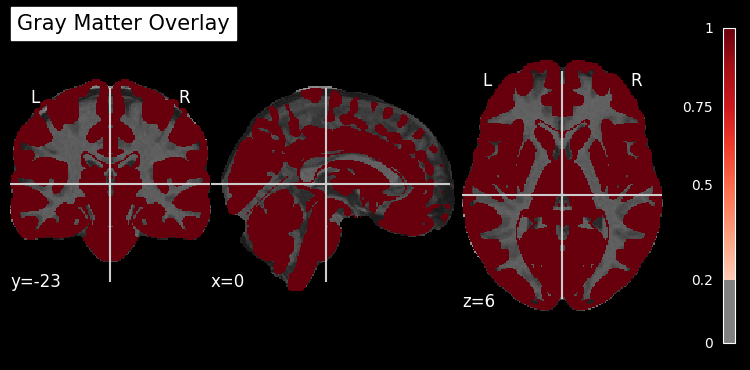

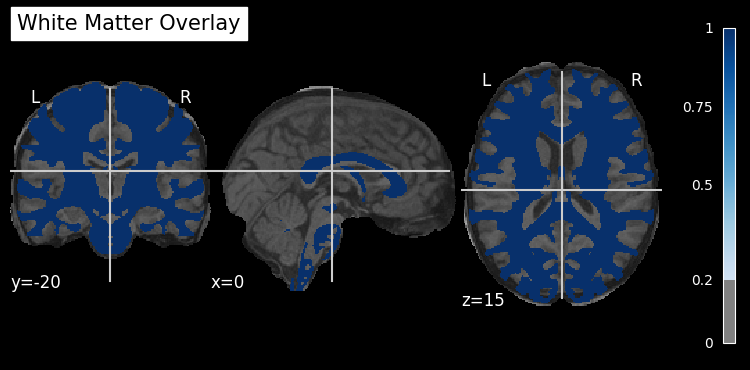

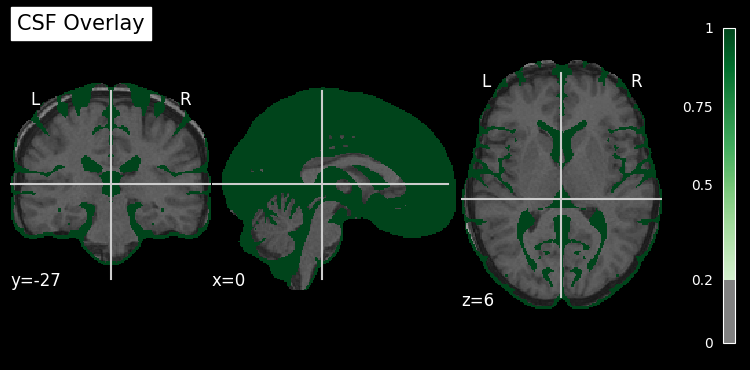

In [33]:
from nilearn.plotting import plot_stat_map

# Overlay the corrected tissue maps
plot_stat_map(gm_segmented, extracted_brain_img, title="Gray Matter Overlay", threshold=0.2, cmap='Reds')
plot_stat_map(wm_segmented, extracted_brain_img, title="White Matter Overlay", threshold=0.2, cmap='Blues')
plot_stat_map(csf_segmented, extracted_brain_img, title="CSF Overlay", threshold=0.2, cmap='Greens')


#### What Happened Here?

- First we have downloaded ICBM152 2009 MNI atlas, which contains probabilistic maps for GM, WM and CSF.

- We have loaded and stored individual tissue probability maps within different variables with the code ```gm_atlas = image.load_img(tissue_maps.gm)
wm_atlas = image.load_img(tissue_maps.wm)
csf_atlas = image.load_img(tissue_maps.csf)```

- MNI atlas and subject MRI have different voxel sizes, orientations and resolutions therefore resampling these atlases to the same space of subject's MRI. This resampling done by ```gm_resampled = image.resample_to_img(gm_atlas, extracted_brain_img, interpolation='continuous', force_resample=True, copy_header=True)
wm_resampled = image.resample_to_img(wm_atlas, extracted_brain_img, interpolation='continuous', force_resample=True, copy_header=True)
csf_resampled = image.resample_to_img(csf_atlas, extracted_brain_img, interpolation='continuous', force_resample=True, copy_header=True)```

- Now we need to convert these resampled tissue probability maps aligned with subject's MRI to binary masks. We will use those masks to decide if tissue in question is the tissue mask is investigating. For this resampled tissue probability maps needs to be converted to numpy array to manipulate them numerically. This done by the ```gm_data = gm_resampled.get_fdata()
wm_data = wm_resampled.get_fdata()
csf_data = csf_resampled.get_fdata()```

- Next, it is required to apply intensity thresholds to decide if tissue will fall into the category of tissue in question or not. This is decided by if voxel exceeds that threshold or not. ```gm_mask = gm_data > 0.3
wm_mask = wm_data > 0.3
csf_mask = csf_data > 0.2``` This code will classify a voxel as gray matter if it has more than 30% probability of being gray matter. Same applied to White matter, I kept CSF probability threshold a little bit less due to it's intensity distribution and spatial characteristics. in T1 images its signal is less. Also strict threshold would cause undersegmentation especially in narrow sulci.

- Next we have converted binary masks back to Nifti images applying them on skull stripped image.

- Lastly we have overlied this segmentations onto subject's MRI to visually verify alignment and segmentation quality.

### Integrating fMRI Data of the Same Subject to Their Anatomical Data

In [36]:
fmri_img=load_mri_images('/Users/ogulcanulu/Desktop/CONN_Demo/sub-01/func/sub-01 func sub-01_task-rest_bold.nii')

fMRI Data Shape: (64, 64, 36, 200)
Affine Matrix:
[[  -3.57841253   -0.28164661   -0.18422806  125.84934235]
 [  -0.2657367     3.57030439   -0.32817888 -114.60878754]
 [  -0.19846058    0.29772574    3.76121759  -56.30370331]
 [   0.            0.            0.            1.        ]]


/var/folders/zk/v8829m_n529b1_hzrntkl8t40000gn/T/ipykernel_22249/255652741.py:4: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_anat(image.mean_img(fmri_img), title="Mean Functional MRI (BOLD)")


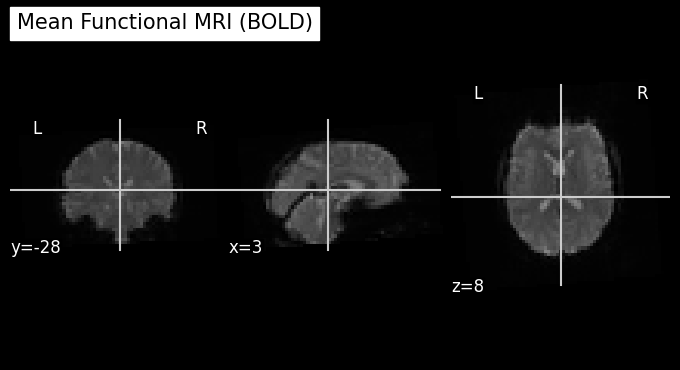

In [37]:
print(f"fMRI Data Shape: {fmri_img.shape}")
print(f"Affine Matrix:\n{fmri_img.affine}")

plotting.plot_anat(image.mean_img(fmri_img), title="Mean Functional MRI (BOLD)")
plotting.show()

---
We have succesfully uploaded our fMRI data and retrieved its properties.

**Shape of the Image (64, 64, 64, 200):** This means that fMRI scan consists of 64 different slices each with resolution of 64 x 64 matrix. Each value in this matrix representing a voxel. **Be aware that it has 4 dimensions while MRI image only contains 3. The last dimension here 200 represents time points. Means that 200 fMRI volumes over time.**

---

#### Comparing Affine Matrices of Anatomical MRI and fMRI shows us there are differences of translation and rotations in space of these two MRI images. 

In [40]:
# Print anatomical MRI affine matrix
print(f"Anatomical MRI Affine Matrix:\n{extracted_brain_img.affine}")

# Print fMRI affine matrix
print(f"Functional MRI Affine Matrix:\n{fmri_img.affine}")

Anatomical MRI Affine Matrix:
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Functional MRI Affine Matrix:
[[  -3.57841253   -0.28164661   -0.18422806  125.84934235]
 [  -0.2657367     3.57030439   -0.32817888 -114.60878754]
 [  -0.19846058    0.29772574    3.76121759  -56.30370331]
 [   0.            0.            0.            1.        ]]


**Two affine matrices show that they are not aligned!**

---

- #### Slice Timing Correction

MRI Scanners acquire functional images one slice at a time, rather than capturing the whole brain simultaneously. Each slice recorded at a slightly different time point within a single volume. What we assume that all slices in a given volume were captured at the same time, which is not the case. This slight delay causes temporal misalignment therefore slice timing correction is needed.

- #### Motion Correction

Even though subjects are instructed to stay still, slight head movements during scanning can introduce misalignment between time points. This needs to be corrected to avoid misinterpretation of signal changes due to motion rather than brain activity.

In [42]:
#Since there is no slice timing correction or motion correction function built in nilearn I will implement a simple and rough
#version however, fmriprep, SPM, AFNI or FSL can be used for precise correction.

from nilearn.image import clean_img

fmri_img_corrected = clean_img(fmri_img, detrend=True, standardize=True)

#KEEP IN MIND THAT THIS DOES NOT REPLACE REAL MOTION CORRECTION BUT CAN MITIGATE MOTION RELATED NOISE

- #### Spatial Normalization

This step ensures that we align subject's own affine matrix and voxel sizes from anatomical data to functional data.

In [44]:
from nilearn.image import resample_img
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
import numpy as np

fmri_img_corrected = resample_img(fmri_img_corrected, target_affine=extracted_brain_img.affine, target_shape=extracted_brain_img.shape)

/var/folders/zk/v8829m_n529b1_hzrntkl8t40000gn/T/ipykernel_22249/2725618035.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  fmri_img_corrected = resample_img(fmri_img_corrected, target_affine=extracted_brain_img.affine, target_shape=extracted_brain_img.shape)
/var/folders/zk/v8829m_n529b1_hzrntkl8t40000gn/T/ipykernel_22249/2725618035.py:6: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  fmri_img_corrected = resample_img(fmri_img_corrected, target_affine=extracted_brain_img.affine, target_shape=extracted_brain_img.shape)


In [63]:
# Print anatomical MRI affine matrix
print(f"Anatomical MRI Affine Matrix:\n{extracted_brain_img.affine}")

# Print fMRI affine matrix
print(f"Functional MRI Affine Matrix:\n{fmri_img_corrected.affine}")

Anatomical MRI Affine Matrix:
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Functional MRI Affine Matrix:
[[   1.    0.    0.  -98.]
 [   0.    1.    0. -134.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]


**Now we can appreciate that both affine matrices are aligned one another!**

### Parcellation

Since both datasets are in the same space, we can proceed with parcellation to extract meaningful region-wise fMRI signals.

In [68]:
from nilearn import datasets, image

atlas_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img = image.load_img(atlas_dataset.maps)
atlas_resampled = image.resample_to_img(atlas_img, fmri_img_corrected, interpolation='nearest')


[get_dataset_dir] Dataset found in /Users/ogulcanulu/nilearn_data/fsl


/var/folders/zk/v8829m_n529b1_hzrntkl8t40000gn/T/ipykernel_22249/503883773.py:5: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resampled = image.resample_to_img(atlas_img, fmri_img_corrected, interpolation='nearest')
/Applications/OpenSesame.app/Contents/Resources/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [70]:
from nilearn.input_data import NiftiLabelsMasker

# Create a masker that extracts mean time series for each region
masker = NiftiLabelsMasker(labels_img=atlas_resampled, standardize=True)

time_series = masker.fit_transform(fmri_img_corrected)


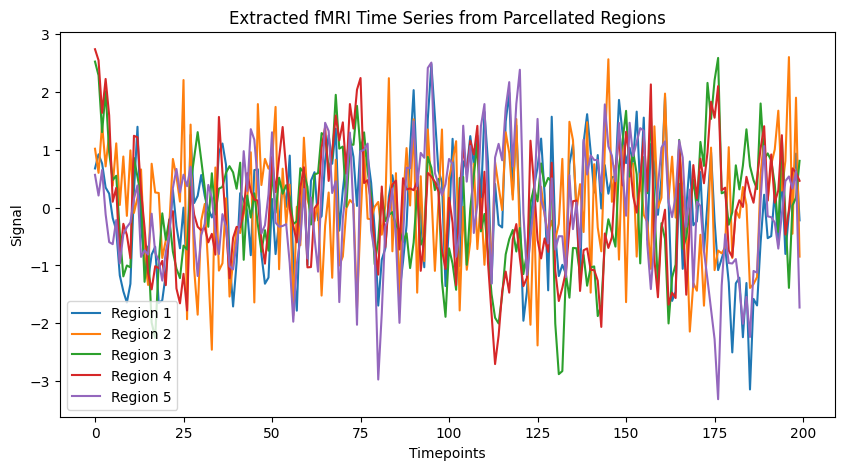

In [73]:
import matplotlib.pyplot as plt

# Select a few regions to visualize
plt.figure(figsize=(10, 5))
plt.plot(time_series[:, :5])  # First 5 regions
plt.title("Extracted fMRI Time Series from Parcellated Regions")
plt.xlabel("Timepoints")
plt.ylabel("Signal")
plt.legend([f"Region {i+1}" for i in range(5)])
plt.show()

#### What Happened Here?

- To parcel our image we have used Harvard-Oxford atlas. Atlas dataset constains predefined regions that we use to extract meaningful fMRI signals.
- Secondly we have resampled the atlas to match our fMRI data -the one also resampled to match anatomical data- we used the code ```atlas_resampled = image.resample_to_img(atlas_img, fmri_img_corrected, interpolation='nearest')``` to align atlas with our preprocessed data.
- NiftiLabelsMasker from Nilearn extracts the mean fMRI time series from each region of the atlas. This step summarizes brain activity in each labeled anatomical region. ``` time_series = masker.fit_transform(fmri_img_corrected)``` applied the parcellation mask to the preprocessed fMRI data.

With this notebook, I have aimed to provide an overview of how preprocessing steps can be performed before analyzing MRI and fMRI data. This is not intended to represent a fully precise or standardized preprocessing pipeline but rather to serve as an educational demonstration of key steps involved. For rigorous and reproducible preprocessing, established neuroimaging toolkits such as FMRIPrep (for fMRI), FreeSurfer (for cortical surface reconstruction), ANTs (for image registration), SPM (for statistical parametric mapping), and AFNI (for advanced fMRI processing) are commonly used and considered state-of-the-art in the field. These tools incorporate robust methods for motion correction, spatial normalization, artifact removal, and advanced segmentation, ensuring consistency and reliability in neuroimaging analyses.